In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate

This reads the PhotometryPlanetRadiiSamplesRedo.csv file that I generated in USPRadiusDistribution.ipynb. It has 1000 radius samples for each USP planet. I make them all into a giant 71000-sample list that I can then slice for each planet.

In [3]:
periodsamples = []
radiisamples = []
kepids = []
meanearthradii = []
earthradiierr = []


## get 1000 planetary radius samples per planet, set up period array
with open('PhotometryPlanetRadiiSamplesRedo2.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        kepids.append(int(row[0]))
        samplelist = list(str(row[1]).split(','))
        samplelist[0] = samplelist[0][1:] # remove brackets
        samplelist[len(samplelist)-1] = samplelist[len(samplelist)-1][:-1] #remove brackets
        sampleslist = [float(i) for i in samplelist]
        meanearthradii.append(np.percentile(sampleslist, 50))
        earthradiierr.append(np.std(sampleslist))
        radiisamples = radiisamples + sampleslist
        print(rownum)
        rownum += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [4]:
print(len(kepids))
print(len(radiisamples))
print(meanearthradii)

62
62000
[1.4828595214497735, 1.1417693178784196, 1.2996020520481479, 1.2494126410326891, 1.3415552743628749, 1.4497973697926798, 1.3675256589917359, 1.177115662137026, 1.4287650565338335, 1.1977587060265571, 1.4376423448906706, 1.3748607503885488, 1.1964126286545085, 1.2054772586114626, 1.6777120973437811, 1.6381244702566227, 1.5085035078126272, 1.7523962699831843, 1.3771860868897927, 1.475721288556048, 1.138500652331357, 1.6502240500806409, 1.7370626082246239, 1.2965043359286446, 1.5480695353675142, 1.4779535788186411, 1.1504360775718523, 0.90034091496404656, 0.90898325912433842, 1.5604521351254783, 1.103815423874319, 1.3077422209468512, 0.96988805803959544, 2.4109850247728475, 1.138400668552263, 1.8770164760504073, 1.1648402043698509, 0.90246797489765829, 1.0322890838796099, 1.4759154079466923, 0.7288173208418447, 1.3628332005798844, 1.506315265073694, 1.7119929460058647, 1.5804141723308331, 1.3537724881845694, 1.2649077618273505, 1.7007727395373511, 1.7218430914569001, 1.4392047108

Set up spherical integration

In [5]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 32)
P_max_hat = np.logspace(0., 2., 32)


cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [6]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(1, len(P_cmb)):
        
        Pcmb = P_cmb[i]
        eos = IronSilicateEOS(Pcmb, P_max_hat[j])
        Pc = eos.P_max
        Pcarr.append(Pc)
        
        def rho(P):
            return eos.eqnOfState(P)
        
        
        m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
        P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure
        
         ## change of variables where q = ln(P)
        def dmdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return (-4 * P * np.pi * (r**2)) / g
        
        def drdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return -P / (rho(P) * g)
            
        def fun(q, x):
            m, r = x
            return dmdq(q, m, r), drdq(q, m, r)
        
        q0 = np.log(P0)
        
        sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

        ## LSODA is the only integration method that works for this order of magnitude
        
        pressure = np.exp(sol.t)
        masses = sol.y[0]
        radii = sol.y[1]
        
        if i == 25 and j == 25:
             pre = np.exp(sol.t)
             mas = sol.y[0]
             rad = sol.y[1]
        
        

        # interpolate masses
        s = interpolate.interp1d(pressure, masses)
        coremass = s(Pcmb) # mass of core
        totalmass = s(1) # total planet mass
        cmf = coremass / totalmass # core mass fraction
        cmfarray[i][j] = cmf
        planetmass[i][j] = totalmass / Emass # in Earth masses
        
        # interpolate radii
        r = interpolate.interp1d(pressure, radii)
        corerad = r(Pcmb) # radius of core
        totalrad = r(1) # total radius
        crf = corerad / totalrad # core radius fraction
        crfarray[i][j] = crf
        planetrad[i][j] = totalrad / Erad # in Earth radii


Set up and flatten arrays for interpolation

In [7]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

In [8]:
flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [13]:
np.random.normal(0.33,0.1)

0.3454342153793616

In [33]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(getmass((getpcmb(radsample, 0.33), getpmaxhat(radsample, 0.33))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append(-1)
        i = i + 1

        
mercurymasssamples = []
i = 0
for radsample in radiisamples:
    try:
        mercurymasssamples.append(getmass((getpcmb(radsample, 0.7), getpmaxhat(radsample, 0.7))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        mercurymasssamples.append(-1)
        i = i + 1
    
        
randmasssamples = []
i = 0
for radsample in radiisamples:
    randomcmf = np.random.normal(0.33,0.1)
    while (randomcmf <= 0):
        randomcmf = np.random.normal(0.33,0.1)
    try:
        randmasssamples.append(getmass((getpcmb(radsample, randomcmf), getpmaxhat(radsample, randomcmf))))
        i = i + 1
    except:
        print("could not interpolate for sample", i, "cmf = ", randomcmf)
        randmasssamples.append(-1)
        i = i + 1
    

could not interpolate for sample 33024
could not interpolate for sample 33029
could not interpolate for sample 33047
could not interpolate for sample 33142
could not interpolate for sample 33143
could not interpolate for sample 33171
could not interpolate for sample 33195
could not interpolate for sample 33240
could not interpolate for sample 33277
could not interpolate for sample 33319
could not interpolate for sample 33400
could not interpolate for sample 33415
could not interpolate for sample 33430
could not interpolate for sample 33436
could not interpolate for sample 33443
could not interpolate for sample 33467
could not interpolate for sample 33512
could not interpolate for sample 33547
could not interpolate for sample 33561
could not interpolate for sample 33573
could not interpolate for sample 33602
could not interpolate for sample 33644
could not interpolate for sample 33696
could not interpolate for sample 33700
could not interpolate for sample 33727
could not interpolate for

In [34]:
print(kepids[33])
print(len(randmasssamples))
print(earthmasssamples[23])

8895758
62000
3.178581924845016


In [36]:
meanearthmasses = []
eartherr = []

meanmercmasses = []
mercerr = []

meanrandmasses = []
randerr = []


file = open('EarthlikeMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(earthmasssamples) // 1000)):
        list1 = []
        list1 = earthmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if (f == -1):
                list1.remove(f)
                print("removed")
        meanearthmasses.append(np.percentile(list1, 50))
        eartherr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        

file = open('MercuryLikeMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(mercurymasssamples) // 1000)):
        list1 = []
        list1 = mercurymasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if (f == -1):
                list1.remove(f)
                print("removed")
        meanmercmasses.append(np.percentile(list1, 50))
        
        mercerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        print(i)
        
file = open('RandomCMFMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(randmasssamples) // 1000)):
        list1 = []
        list1 = randmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if (f == -1):
                list1.remove(f)
                print("removed")
        meanrandmasses.append(np.percentile(list1, 50))
        randerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
removed
removed
removed
removed
removed


In [37]:
print(meanearthmasses)

[4.4248151971636354, 1.6991286542274873, 2.713264067453435, 2.3274105505944949, 3.0349987937864062, 4.0601970109112253, 3.2343924101082648, 1.8882798720523926, 3.8217311662147058, 1.9999067668694719, 3.9221346327273539, 3.2901150953633751, 1.9930800696896687, 2.0410690739217019, 7.1111898548703687, 6.4855072073611808, 4.709951196147637, 8.3512824962408683, 3.3083775226583874, 4.3495917129889952, 1.6812680959787918, 6.6782834152661437, 8.0487900412580249, 2.6895809949397527, 5.147445759206458, 4.3733591176682935, 1.7459973590656606, 0.73391861481294707, 0.75596716197186131, 5.2840519346499857, 1.4948627236741809, 2.7754429794292816, 0.9555585011158505, 34.604791468061208, 1.6806959323113695, 11.175766857877989, 1.8230066173348092, 0.73953034147306851, 1.1839707208159929, 4.34887812841494, 0.35623288371226014, 3.1995659993357224, 4.6861701697042273, 7.6528577906394695, 5.5682439313083947, 3.1274489427830447, 2.4469956418032135, 7.4755096050312133, 7.8086653986922983, 3.9417627693824295, 

In [38]:
print(eartherr)

[1.4302603474761613, 0.20975085614534958, 0.30312818023423743, 0.1136585482982075, 0.59793786270360638, 0.91662963315326973, 0.68787400581524993, 0.40725436331223641, 0.26568242322688163, 0.3298374353443923, 0.50198353537637797, 0.21039609183820765, 0.15429616440462299, 0.44078841664258511, 1.147445189678659, 0.78532753261779475, 0.36462838929893876, 0.86934614626291806, 0.40108302953109243, 0.8532997764728586, 0.22505969260212971, 2.3654484423487387, 1.3504691143584582, 0.16591277648383393, 0.76623512211189559, 0.29385257476711801, 0.20993864391214748, 0.26951082565154044, 0.14152467987821743, 0.84664422985694798, 0.26661494523781148, 1.2418566096607599, 0.13333753707348636, 32.684126254295883, 0.23605211273338614, 2.3918434436616538, 0.1875088304364716, 0.054428797899884279, 0.30414288808353973, 0.68024680592166342, 0.034094324911787703, 0.76139731020204804, 0.2799978643457865, 0.91246786507536548, 0.3794574118930974, 0.60867362076816334, 0.45277192387744253, 0.85835612502076519, 0.3

In [140]:
meanplanradband = [1.5142207897134599, 1.1436702581725311, 1.29995494508817, 1.3189668428623589, 1.2269233123544596, 1.3416469177901493, 1.4501086309196631, 1.1346210885160928, 1.3678308145394535, 1.1773182912719149, 1.4290130565850703, 1.1924524835284092, 1.4377185513117101, 1.3778832575370645, 1.1987523431558333, 1.2031537496435152, 1.6789372289268041, 1.6367597521676016, 1.5102166858962964, 1.2450243555135487, 1.7554218547394591, 1.3750204896572571, 1.4763165953082957, 1.1374076117298841, 1.6579424766739201, 1.7474079535815623, 1.2976710643762763, 1.5469721327227073, 1.4803792515077325, 1.1485935543428036, 0.91107113014034191, 0.90912534283711122, 1.5575626745682334, 1.1016976539308982, 1.306567461499029, 0.97216101853985515, 2.3659198651407789, 1.1388767324032376, 1.8878774237581295, 1.1603625846498211, 0.90433911227498831, 1.0330717061012351, 1.4773091465919181, 0.72919497667200817, 1.3558223565388077, 1.5039103713589141, 1.7185699399360876, 1.5759094919342289, 1.3535027097987864, 1.2676025968602689, 1.6999474483312145, 1.7232645141015186, 1.4375272444998766, 1.2675926110963895, 1.0322004078256348, 1.742165191417018, 1.5358602614962091, 1.4630747310708188, 1.3776544531211727, 1.0864475036950445, 1.2169836268301546, 1.4158706344921796, 1.025515766195459, 2.5964514405645982, 0.98803480896675566, 1.3933339279057437, 1.7206936810871374, 1.5010015006680679, 1.4465641351682894, 1.0878734373223826, 1.5076561842415757]

radsss = []
massss = []
cmfsss = []

for i in range(len(planetrad[0])):
    for j in range(len(planetrad)):
        radsss.append(planetrad[i][j])
        massss.append(planetmass[i][j])
        cmfsss.append(cmfarray[i][j])

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


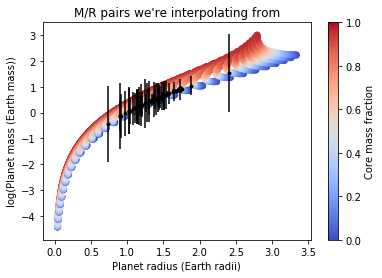

In [142]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, np.log10(massss), c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, np.log10(meanearthmasses),'k.')
plt.errorbar(meanearthradii, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

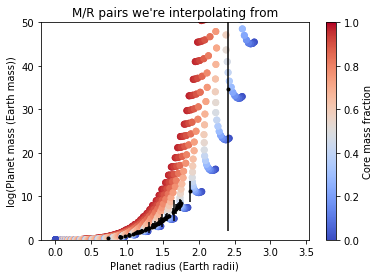

In [144]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, massss, c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, meanearthmasses,'k.')
plt.errorbar(meanearthradii, meanearthmasses, ls= 'none',yerr = eartherr, ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.ylim(0, 50)
plt.show()

In [158]:
kepids.index(11600889)

50

In [159]:
print(meanearthmasses[50])
print(eartherr[50])

2.46144061849
0.174592601683


Now I'm going to do the interpolation for planets with measured masses.

In [182]:
flatmass = planetmass.flatten()


For Kepler-10b, the measured mass is 3.72 +/- 0.42 Earth masses.

In [183]:
import scipy.stats
dist = scipy.stats.norm(3.72, 0.42)

weights = []
for mass in flatmass:
    weights.append(scipy.stats.norm(3.72, 0.42).pdf(mass))

In [48]:
kepid = []
koi = []
adivr = []
per = []
starrad = []
pradii = []
numstars = []


with open('USPHostProperties.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         if rownum > 0:
             kepid.append(int(row[0]))
             koi.append(int(row[1]))
             adivr.append(float(row[2]))
             per.append(float(row[3]))
             starrad.append(float(row[11]))
             pradii.append(float(row[12]))
             numstars.append(float(row[13]))
         rownum += 1

falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

todelete = []
for j in range(0,len(falsepositives)):
    for i in range(0, len(kepid)):
        if kepid[i] == falsepositives[j]:
            todelete.append(i)
            
todelete.reverse()
for k in todelete:
    del kepid[k]
    del koi[k]
    del per[k]
    del adivr[k]
    del numstars[k]
    
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
numstars = [numstars[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
print(len(per))
print(len(numstars))

62
62


len massrand 62


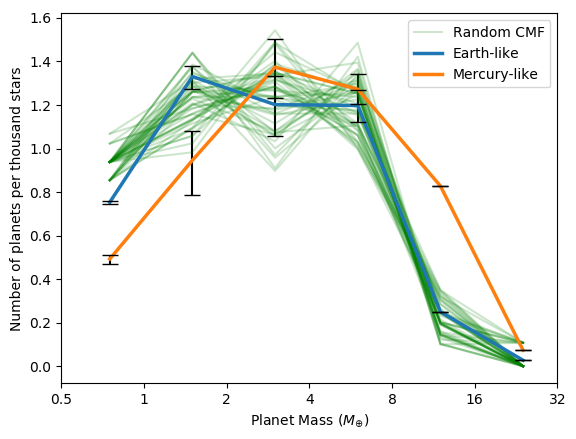

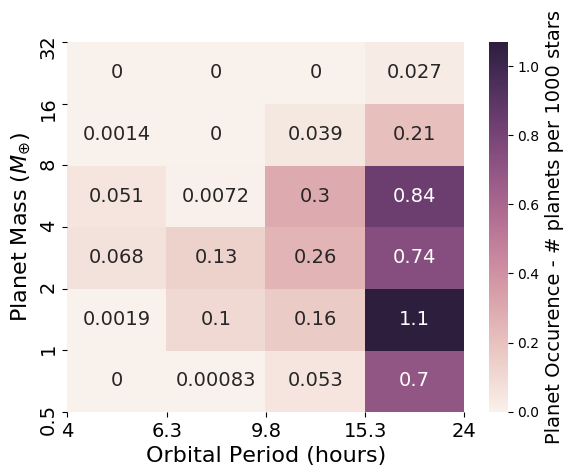

In [71]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
earthsamples = []
earthperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('EarthlikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             earthperiodsamples.append(float(per[kepid.index(kepid2)]))
         earthsamples = earthsamples + samplelist
         rownum += 1

mercurysamples = []
mercperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('MercuryLikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             mercperiodsamples.append(float(per[kepid.index(kepid2)]))
         mercurysamples = mercurysamples + samplelist
         rownum += 1

randsamples = []
massrand = []
randperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('RandomCMFMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             randperiodsamples.append(float(per[kepid.index(kepid2)]))
         massrand.append(np.percentile(list1, 50))
         randsamples = randsamples + samplelist
         rownum += 1

print("len massrand", len(massrand))

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
    
earthmasssum = np.zeros(len(massbins)-1)   
mercmasssum = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum[j] += eartharray[j][i]*1000
        mercmasssum[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum[i]/earthtransitsum[i])*high) - earthmasssum[i]
            earthwilsonlow[i] = ((earthmasssum[i]/earthtransitsum[i])*low) - earthmasssum[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum[i]/merctransitsum[i])*high) - mercmasssum[i]
            mercwilsonlow[i] = ((mercmasssum[i]/merctransitsum[i])*low) - mercmasssum[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

for o in range(0,49):
    massarray = np.zeros((len(massbins)-1,len(perbins)-1))
    massrand = []
    for j in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
        except:
            print("couldn't interpolate", randomcmf)
    for i in range(len(massrand)):
        for j in range(len(perbins)-1):
            for k in range(len(massbins)-1):
                if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                    massarray[k][j] += (f[i])
    masssum = np.zeros(len(massbins)-1)  
    for j in range(len(massbins) - 1):
        for i in range(len(perbins)-1):
            masssum[j] += massarray[j][i]*1000
    plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', linewidth = 2.5)

plt.errorbar(massticks,np.flip(mercmasssum,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)')
plt.ylabel('Number of planets per thousand stars')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
plt.legend()

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show()
